## Importing necessary packages and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Stylized Duration and Convexity

### 1.1. Calculate duration

**Parameters:**
* Face Value ($F$): $100
* Time to Maturity ($T$): 10 years
* Coupon Rate ($c$): 3% (annual)
* Yield to Maturity ($y$): 5% (annual, semiannual compounding)
* Frequency ($m$): 2 (semiannual)

**Formulas:**
The cash flows occur at $t = 0.5, 1.0, \dots, 10.0$.
The periodic yield is $r = y/m = 2.5\%$.
The periodic coupon is $C = (c \times F) / m = \$1.50$.

The **Price ($P$)** is the present value of cash flows:
$$P = \sum_{n=1}^{N} \frac{CF_n}{(1+r)^n}$$

**Macaulay Duration ($D_{mac}$)** (in years):
$$D_{mac} = \frac{1}{P} \sum_{n=1}^{N} \frac{n}{m} \times \frac{CF_n}{(1+r)^n}$$

**Modified Duration ($D_{mod}$)**:
$$D_{mod} = \frac{D_{mac}}{1+r}$$

In [2]:
def calculate_duration_metrics(face_value=100, coupon_rate=0.03, ytm=0.05, years=10, freq=2):
    periods = years * freq
    r_periodic = ytm / freq
    c_periodic = (coupon_rate * face_value) / freq
    
    # Time vector (0.5, 1.0, ..., 10.0)
    t_vec = np.arange(1, periods + 1) / freq
    
    # Cash flow vector
    cf_vec = np.full(periods, c_periodic)
    cf_vec[-1] += face_value  # Add principal to last payment
    
    # Present Value of Cash Flows
    discount_factors = (1 + r_periodic) ** -(t_vec * freq)
    pv_vec = cf_vec * discount_factors
    price = np.sum(pv_vec)
    
    # Macaulay Duration (Weighted Average Time)
    weighted_time = np.sum(t_vec * pv_vec)
    mac_dur = weighted_time / price
    
    # Modified Duration
    mod_dur = mac_dur / (1 + r_periodic)
    
    return price, mac_dur, mod_dur

# 1.1 Calculation
price_1, mac_1, mod_1 = calculate_duration_metrics(coupon_rate=0.03)

# Display the results
results_df = pd.DataFrame({
    "Metric": ["Price", "Macaulay Duration", "Modified Duration"],
    "Value": [price_1, mac_1, mod_1],
    "Unit": ["USD", "years", "years"]
})

results_df = results_df.set_index("Metric")
display(results_df.style.format({"Value": "{:.6f}"}))

,Value,Unit
Metric,,
Price,84.410838,USD
Macaulay Duration,8.570879,years
Modified Duration,8.361834,years


### 1.2. Duration Calculation (10Y, 7% Coupon)

Keeping all other parameters constant ($T=10$, $y=5\%$), we change the coupon rate to 7%.

In [3]:
# Calculation
price_2, mac_2, mod_2 = calculate_duration_metrics(coupon_rate=0.07)

results_df_2 = pd.DataFrame({
    "Metric": ["Price", "Macaulay Duration", "Modified Duration"],
    "Value": [price_2, mac_2, mod_2],
    "Unit": ["USD", "years", "years"]
})
results_df_2 = results_df_2.set_index("Metric")
display(results_df_2.style.format({"Value": "{:.6f}"}))

,Value,Unit
Metric,,
Price,115.589162,USD
Macaulay Duration,7.564844,years
Modified Duration,7.380336,years


### 1.3. Duration Calculation (10Y, 5% Coupon)

Keeping all other parameters constant, we change the coupon rate to 5%.
*Note: Since Coupon Rate = Yield, the bond should trade at Par ($100).*

In [4]:
# Calculation
price_3, mac_3, mod_3 = calculate_duration_metrics(coupon_rate=0.05)

results_df_3 = pd.DataFrame({
    "Metric": ["Price", "Macaulay Duration", "Modified Duration"],
    "Value": [price_3, mac_3, mod_3],
    "Unit": ["USD", "years", "years"]
})
results_df_3 = results_df_3.set_index("Metric")
display(results_df_3.style.format({"Value": "{:.6f}"}))

,Value,Unit
Metric,,
Price,100.000000,USD
Macaulay Duration,7.989446,years
Modified Duration,7.794581,years


### 1.4. Impact of Coupon Rate on Duration

**Comparison of Results:**
* **3% Coupon:** Modified Duration $\approx 8.36$ years
* **5% Coupon:** Modified Duration $\approx 7.79$ years
* **7% Coupon:** Modified Duration $\approx 7.38$ years

**Explanation:**
There is an **inverse relationship** between the coupon rate and duration. As the coupon rate increases, the duration decreases.

**Economic Intuition:**
Duration represents the weighted average time to receive the bond's cash flows.
1.  **Higher Coupon:** A larger portion of the total return is received earlier in the form of coupon payments, reducing the duration.
2.  **Lower Coupon:** A larger proportion of the bond's value comes from the final principal repayment at year 10. This pushes the weighted average time out further, increasing duration.

## 2. Hedging Duration

In [5]:
# Load Data
file_path = '../data/treasury_ts_duration_2025-05-30.xlsx'
df_dirty = pd.read_excel(file_path, sheet_name='dirty price', index_col='quote date')
df_clean = pd.read_excel(file_path, sheet_name='clean price', index_col='quote date')
df_dur   = pd.read_excel(file_path, sheet_name='duration', index_col='quote date')

# Load Database Sheet 
df_db = pd.read_excel(file_path, sheet_name='database', index_col=0)

# Filter for the specific securities in the problem
securities = [207391, 207392]

# Ensure data types are floats and indices are datetime
df_clean = df_clean[securities].astype(float)
df_dirty = df_dirty[securities].astype(float)
df_dur   = df_dur[securities].astype(float)
df_clean.index = pd.to_datetime(df_clean.index)
df_dirty.index = pd.to_datetime(df_dirty.index)
df_dur.index   = pd.to_datetime(df_dur.index)

### 2.1. Initial Hedge Calculation
 
We need to calculate the initial short position required to hedge a \$10,000 long position in security 207391.
 
**Mathematical Derivation:**  
To be duration neutral, the Dollar Duration (DD) of the portfolio must be zero.
 
$$
DD_\mathrm{portfolio} = DD_\mathrm{long} + DD_\mathrm{short} = 0
$$
 
$$
DD = \text{Market Value} \times \text{Duration}
$$
 
$$
MV_\mathrm{long} \times D_\mathrm{long} + MV_\mathrm{short} \times D_\mathrm{short} = 0
$$
 
Solving for the Market Value of the short position ($MV_\mathrm{short}$):
 
$$
MV_\mathrm{short} = -MV_\mathrm{long} \times \frac{D_\mathrm{long}}{D_\mathrm{short}}
$$

In [6]:
# Parameters
target_mv_long = 10000 
id_long = 207391
id_short = 207392

# Get data for the start date (t0)
t0 = df_dur.index[0]
dur_long_t0 = df_dur.loc[t0, id_long]
dur_short_t0 = df_dur.loc[t0, id_short]

# Calculate Hedge Ratio and Short Market Value
hedge_ratio = dur_long_t0 / dur_short_t0
mv_short_initial = -target_mv_long * hedge_ratio

# Display the summary
summary_df = pd.DataFrame({
    "Value": [
        t0.date(),
        round(dur_long_t0, 4),
        round(dur_short_t0, 4),
        round(hedge_ratio, 4),
        f"${mv_short_initial:.2f}"
    ]
}, index=[
    "Date",
    f"Duration (Long - {id_long})",
    f"Duration (Short - {id_short})",
    "Hedge Ratio (Long/Short)",
    "Required Short Position (MV)"
])

display(summary_df)

,Value
Date,2019-08-09
Duration (Long - 207391),9.2895
Duration (Short - 207392),22.0001
Hedge Ratio (Long/Short),0.4222
Required Short Position (MV),$-4222.48


### 2.2. Dynamic Hedging

In this step, we **simulate the strategy daily**, *ignoring coupon payments* for the PnL calculation. We focus solely on price changes (pure price PnL).
 
**Methodology**

- **Rebalance (Start of Day $t$):**
     - Reset the Long position to exactly $10,000.
     - Calculate the new Short position required to neutralize duration, using the updated durations at time $t$.
 
- **Hold (From Day $t$ to $t+1$):**
     - Hold these positions overnight.
 
- **PnL Calculation:**
     - Compute profit/loss based on the change in **Dirty Price**.
 
**Why Dirty Price?**
Dirty price represents the *actual market value* of the bond (Clean Price + Accrued Interest). When you buy or sell bonds in the market, you transact at the Dirty Price.

**PnL Formula**

$$
\mathrm{PnL}_{\text{total}} = \left( N_{\text{long}} \times \Delta P_{\text{long}} \right) + \left( N_{\text{short}} \times \Delta P_{\text{short}} \right)
$$
 
Where:
 
- $N_{\text{long}}$, $N_{\text{short}}$ = Number/size of bonds in Long and Short positions  
- $\Delta P_{\text{long}}$, $\Delta P_{\text{short}}$ = Change in Dirty Price for each position

,Hedged (No Cpn),Long Only (No Cpn)
Mean,0.32,-0.42
Std Dev,21.05,43.92
Min,-98.01,-320.39
Max,118.04,276.31


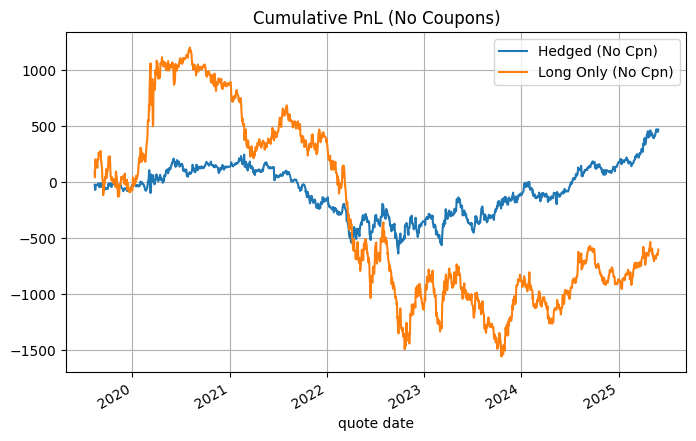

In [7]:
# Dynamic Hedging (No Coupons)
dates = df_dirty.index
pnl_hedged_no_cpn = []
pnl_long_only_no_cpn = []

for i in range(len(dates) - 1):
    t_curr = dates[i]
    t_next = dates[i+1]
    
    # Rebalancing at t_curr
    # Prices and Durations
    P_long = df_dirty.loc[t_curr, id_long]
    P_short = df_dirty.loc[t_curr, id_short]
    D_long = df_dur.loc[t_curr, id_long]
    D_short = df_dur.loc[t_curr, id_short]
    
    # Position Sizes (Units = Target Market Value / Price)
    # Long: Always reset to $10k MV
    units_long = target_mv_long / P_long
    
    # Short: Hedge Duration
    # MV_short = -MV_long * (D_long / D_short)
    mv_short = -target_mv_long * (D_long / D_short)
    units_short = mv_short / P_short
    
    # Calculate PnL at t_next
    # Prices at t_next
    P_long_next = df_dirty.loc[t_next, id_long]
    P_short_next = df_dirty.loc[t_next, id_short]
    
    # Price Changes
    delta_P_long = P_long_next - P_long
    delta_P_short = P_short_next - P_short
    
    # Daily PnL (Market Value change)
    daily_pnl_long = units_long * delta_P_long
    daily_pnl_short = units_short * delta_P_short
    
    pnl_hedged_no_cpn.append(daily_pnl_long + daily_pnl_short)
    pnl_long_only_no_cpn.append(daily_pnl_long)

# Store results
df_pnl_2_2 = pd.DataFrame({
    'Hedged (No Cpn)': pnl_hedged_no_cpn,
    'Long Only (No Cpn)': pnl_long_only_no_cpn
}, index=dates[1:])

# Stats
stats_2_2 = df_pnl_2_2.agg(['mean', 'std', 'min', 'max'])
stats_2_2.index = ['Mean', 'Std Dev', 'Min', 'Max']
display(stats_2_2.style.format("{:.2f}"))

# Plot
df_pnl_2_2.cumsum().plot(title="Cumulative PnL (No Coupons)", figsize=(8,5))
plt.grid(True)
plt.show()

### 2.3. Explanation of Non-Zero PnL

**Question:**  
*Why is the PnL of the hedged portfolio not exactly zero?*

**Answer:**  
Even with a theoretically "perfect" duration hedge updated daily, the PnL is not zero due to two primary factors:

1. **Convexity Mismatch:**  
   Duration is a first-order (linear) approximation of the bond price change:
   
   $$
   \Delta P \approx -D \times P \times \Delta y + \frac{1}{2} C \times P \times (\Delta y)^2
   $$
   
   The hedge neutralizes the first term (Duration $D$), but *does not* neutralize the second term (Convexity $C$). If the long and short bonds have different convexities, large yield changes will result in residual PnL.  <br><br>
2. **Basis Risk (Yield Curve Shape Changes):**  
   Duration hedging assumes a *parallel shift* in the yield curve (yields for all maturities move by the exact same amount).  
   In reality, the yield curve can steepen, flatten, or twist. If the yield of the 10-year bond changes by 5bps but the yield of the hedging instrument changes by 3bps, the hedge ratio (calculated assuming equal moves) will be incorrect for that specific day, leading to variation PnL.

### 2.4. Coupon Identification

We must identify when coupons are paid. We can deduce this from the provided data.

- **Accrued Interest ($AI$):**  
  $AI = \text{Dirty Price} - \text{Clean Price}$
- Accrued interest grows linearly every day and drops to zero (or near zero) immediately after a coupon is paid.
- **Coupon Amount:**  
  The drop in accrued interest plus any slight difference in clean price change.

**Approach:**  
We will calculate accrued interest each day and detect the drops to identify the coupon payment dates.

In [8]:
# Calculate Accrued Interest
df_accrued = df_dirty - df_clean

# Calculate daily change in Accrued Interest
diff_accrued = df_accrued.diff()

# Identify Coupon Dates 
# Look for large negative changes in Accrued Interest as this signifies the reset after payment.
is_coupon_day = diff_accrued < -1e-6

coupon_data = []

# Iterate through the boolean mask to extract dates and estimates
for col in is_coupon_day.columns:
    coupon_dates = is_coupon_day.index[is_coupon_day[col]]
    
    for date in coupon_dates:
        # The coupon amount is approximately the drop in accrued interest.
        # The absolute drop in accrued is the best proxy for coupon received
        estimated_coupon = -diff_accrued.loc[date, col]
        
        coupon_data.append({
            'Date': date,
            'Security': col,
            'Estimated Coupon': estimated_coupon.round(1)
        })

df_coupons_list = pd.DataFrame(coupon_data).sort_values('Date')
display(df_coupons_list)

# Create a DataFrame of cashflows (0 on normal days, coupon amt on coupon days)
df_cashflows = pd.DataFrame(0.0, index=dates, columns=securities)

for _, row in df_coupons_list.iterrows():
    # Store the positive cashflow
    df_cashflows.loc[row['Date'], row['Security']] = row['Estimated Coupon']

,Date,Security,Estimated Coupon
0,2020-02-18,207391,0.8
11,2020-02-18,207392,1.1
1,2020-08-17,207391,0.8
12,2020-08-17,207392,1.1
2,2021-02-16,207391,0.8
13,2021-02-16,207392,1.1
3,2021-08-16,207391,0.8
14,2021-08-16,207392,1.1
4,2022-02-15,207391,0.8
15,2022-02-15,207392,1.1


### 2.5. Hedging PnL with Coupons

Now we incorporate the coupon cash flows into the PnL.

- **Long Position:** Receives the coupon (*cash inflow*).
- **Short Position:** Pays the coupon (*cash outflow*).

**Note on Timing:**  
On coupon payment dates, the *Dirty Price* of the bond drops because accrued interest resets to zero. If we do not add the coupon cash flow back, it appears as a large loss. Including the coupon ensures that the calculated PnL reflects the true economic outcome.

,Hedged (Total),Long Only (Total)
Mean,0.63,0.22
Std Dev,20.77,43.10
Min,-98.01,-320.39
Max,118.04,276.31


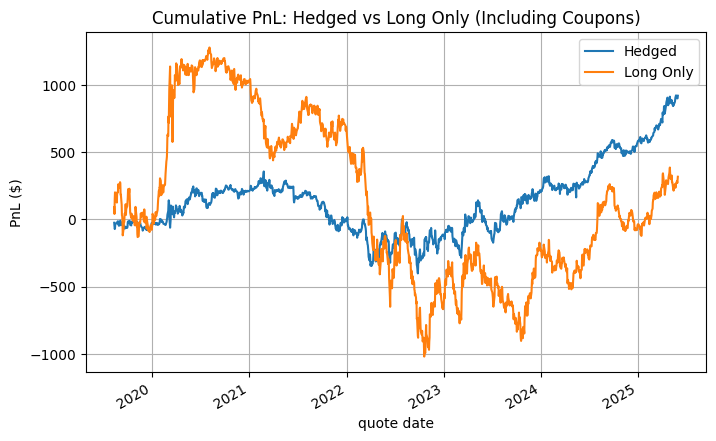

In [9]:
# Dynamic Hedging with Coupons

pnl_hedged_w_cpn = []
pnl_long_only_w_cpn = []

for i in range(len(dates) - 1):
    t_curr = dates[i]
    t_next = dates[i+1]
    
    # Rebalancing (Same as 2.2)
    P_long = df_dirty.loc[t_curr, id_long]
    P_short = df_dirty.loc[t_curr, id_short]
    D_long = df_dur.loc[t_curr, id_long]
    D_short = df_dur.loc[t_curr, id_short]
    
    units_long = target_mv_long / P_long
    mv_short = -target_mv_long * (D_long / D_short)
    units_short = mv_short / P_short
    
    # Calculate PnL (With Coupons)
    P_long_next = df_dirty.loc[t_next, id_long]
    P_short_next = df_dirty.loc[t_next, id_short]
    
    # Coupon Cashflow at t_next (if any)
    C_long = df_cashflows.loc[t_next, id_long]
    C_short = df_cashflows.loc[t_next, id_short]
    
    # Total PnL = (Price Change + Coupon) * Units
    # For Short, we pay the coupon, so it naturally works out:
    # units_short is negative. If C_short is positive (coupon paid)
    step_pnl_long = units_long * (P_long_next - P_long + C_long)
    step_pnl_short = units_short * (P_short_next - P_short + C_short)
    
    pnl_hedged_w_cpn.append(step_pnl_long + step_pnl_short)
    pnl_long_only_w_cpn.append(step_pnl_long)

# Store Results
df_pnl_2_5 = pd.DataFrame({
    'Hedged (Total)': pnl_hedged_w_cpn,
    'Long Only (Total)': pnl_long_only_w_cpn
}, index=dates[1:])

# Display Stats
stats_2_5 = df_pnl_2_5.agg(['mean', 'std', 'min', 'max'])
stats_2_5.index = ['Mean', 'Std Dev', 'Min', 'Max']
display(stats_2_5.style.format("{:.2f}"))

# Plot Comparison
fig, ax = plt.subplots(figsize=(8,5))
df_pnl_2_5['Hedged (Total)'].cumsum().plot(ax=ax, label='Hedged')
df_pnl_2_5['Long Only (Total)'].cumsum().plot(ax=ax, label='Long Only')
ax.set_title("Cumulative PnL: Hedged vs Long Only (Including Coupons)")
ax.set_ylabel("PnL ($)")
ax.legend()
plt.grid(True)
plt.show()